<table style="width:100%">
<tr>
<td style="vertical-align:middle; text-align:left;">
<font size="2">
Supplementary code for the <a href="http://mng.bz/orYv">Build a Large Language Model From Scratch</a> book by <a href="https://sebastianraschka.com">Sebastian Raschka</a><br>
<br>Code repository: <a href="https://github.com/rasbt/LLMs-from-scratch">https://github.com/rasbt/LLMs-from-scratch</a>
<br>汉化的库: <a href="https://github.com/GoatCsu/CN-LLMs-from-scratch.git">https://github.com/GoatCsu/CN-LLMs-from-scratch.git</a>
</font>
</td>
<td style="vertical-align:middle; text-align:left;">
<a href="http://mng.bz/orYv"><img src="../image/cover-small.webp" width="100px"></a>
</td>
</tr>
</table>


# 第四章: 从零开始构建 GPT 模型

In [34]:
from importlib.metadata import version

import matplotlib
import tiktoken
import torch

print("matplotlib version:", version("matplotlib"))
print("torch version:", version("torch"))
print("tiktoken version:", version("tiktoken"))
#加载并确认版本

matplotlib version: 3.10.8
torch version: 2.10.0
tiktoken version: 0.12.0


- 在这一章我们要用类GPT LLM架构
- 下一章就是训练LLM了

<img src="../image/01.webp" width="500px">

## 4.1 LLM架构

- 第 1 章讨论了 GPT 和 Llama 等模型，这些模型基于原始 Transformer 架构的解码器部分，按顺序生成单词。
- 因此，这些大语言模型（LLM）通常被称为“类解码器”的 LLM。
- 与传统的深度学习模型相比，LLM 的规模更大，这主要是由于其参数数量庞大，而非代码量的增加。
- 我们将看到，在 LLM 的架构中，许多元素是重复的。

<img src="../image/02.webp" width="400px">

- 在前几章中，为了便于说明，我们使用了较小的嵌入维度对标记输入和输出进行处理，以确保内容能够显示在单页内。
- 本章将讨论与小型 GPT-2 模型类似的嵌入和模型规模。
- 我们将具体实现最小的 GPT-2 模型架构（1.24 亿参数）。该架构来源于 Radford 等人的报告 [《Language Models are Unsupervised Multitask Learners》](https://cdn.openai.com/better-language-models/language_models_are_unsupervised_multitask_learners.pdf)（需要注意的是，初始报告中参数数量被列为 1.17 亿，但这一错误在模型权重库中已被更正）。
- 第 6 章将展示如何将预训练权重加载到我们的实现中，这些权重可兼容 3.45 亿、7.62 亿和 15.42 亿参数规模的模型。

- 123million参数的GPT-2配置如下:

In [35]:
GPT_CONFIG_124M = {
    "vocab_size": 50257,    # Vocabulary size
    "context_length": 1024, # Context length
    "emb_dim": 768,         # Embedding dimension
    "n_heads": 12,          # Number of attention heads
    "n_layers": 12,         # Number of layers
    "drop_rate": 0.1,       # Dropout rate
    "qkv_bias": False       # Query-Key-Value bias
}
#初始化定义需要的各种超参数

- 我们使用简短的变量名，以避免代行过长。
- `"vocab_size"` 表示词汇表大小，共 50,257 个单词，由第 2 章介绍的 BPE 分词器支持。
- `"context_length"` 表示模型的最大输入标记数，依赖于第 2 章的位置信息嵌入。
- `"emb_dim"` 是标记输入的嵌入维度，将每个标记转换为 768 维向量。
- `"n_heads"` 是多头注意力机制中的注意力头数量，详见第 3 章。
- `"n_layers"` 是模型中 Transformer 块的数量，后续章节会详细实现。
- `"drop_rate"` 是 dropout 机制的强度，设置为 0.1，表示训练时丢弃 10% 的隐藏单元以防止过拟合（第 3 章讨论）。
- `"qkv_bias"` 决定多头注意力机制中的 `Linear` 层是否包含偏置向量。现代 LLM 通常禁用此选项，但在第 5 章加载 OpenAI 的 GPT-2 预训练权重时，会重新启用以保持兼容性。

<img src="../image/03.webp" width="500px">

In [36]:
import torch
import torch.nn as nn


class DummyGPTModel(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"])
        # 词嵌入层，将输入索引转换为词向量，词表大小由字典大小和特征维度决定。
        self.pos_emb = nn.Embedding(cfg["context_length"], cfg["emb_dim"])
        # 位置信息嵌入层，基于文本长度和特征维度生成位置信息。
        self.drop_emb = nn.Dropout(cfg["drop_rate"])
        # Dropout 层，用于随机丢弃一部分嵌入信息以减少过拟合。

        # 使用多个 Transformer 块（占位符）
        self.trf_blocks = nn.Sequential(
            *[DummyTransformerBlock(cfg) for _ in range(cfg["n_layers"])]
        )
        # Transformer 模块的堆叠，模型核心部分。

        # 使用归一化层（占位符）
        self.final_norm = DummyLayerNorm(cfg["emb_dim"])
        # 最终归一化层，用于调整特征分布。

        self.out_head = nn.Linear(
            cfg["emb_dim"], cfg["vocab_size"], bias=False
        )
        # 输出层，将特征映射到词表分布，最终预测输出单词。

    def forward(self, in_idx):
        batch_size, seq_len = in_idx.shape
        # 获取批次大小和序列长度。

        tok_embeds = self.tok_emb(in_idx) 
        # 根据输入索引生成词嵌入。
        pos_embeds = self.pos_emb(torch.arange(seq_len, device=in_idx.device))
        # 生成对应的位置信息嵌入。

        x = tok_embeds + pos_embeds
        # 将词嵌入和位置信息嵌入相加。
        x = self.drop_emb(x)
        # 应用 Dropout 随机丢弃部分信息。
        x = self.trf_blocks(x)
        # 通过多个 Transformer 块处理特征。
        x = self.final_norm(x)
        # 应用最终的归一化层。
        logits = self.out_head(x)
        # 将隐藏状态映射到词表分布，生成预测结果。
        return logits


class DummyTransformerBlock(nn.Module):
    # Transformer 块的占位类。
    def __init__(self, cfg):
        super().__init__()
        # 占位，实际模型应实现注意力机制和前馈网络。

    def forward(self, x):
        # 此块不执行任何操作，仅返回输入。
        return x


class DummyLayerNorm(nn.Module):
    # 归一化层的占位类。
    def __init__(self, normalized_shape, eps=1e-5):
        super().__init__()
        # 参数用于模拟 LayerNorm 的接口。

    def forward(self, x):
        # 此层不执行任何操作，仅返回输入。
        return x

<img src="../image/04.webp" width="500px">

In [37]:
import tiktoken

tokenizer = tiktoken.get_encoding("gpt2")
#召唤gpt大神
batch = []

txt1 = "Every effort moves you"
txt2 = "Every day holds a"

batch.append(torch.tensor(tokenizer.encode(txt1)))
batch.append(torch.tensor(tokenizer.encode(txt2)))
#编码输入文本
batch = torch.stack(batch, dim=0)
#按照横向来叠加两个向量
print(batch)

tensor([[6109, 3626, 6100,  345],
        [6109, 1110, 6622,  257]])


In [38]:
# 设置随机种子以确保结果可复现
# 这样每次运行代码时,模型的初始化权重都是相同的
torch.manual_seed(123)

# 使用之前定义的 GPT_CONFIG_124M 配置创建一个占位 GPT 模型实例
# DummyGPTModel 是一个简化版本,用于演示模型的基本结构
model = DummyGPTModel(GPT_CONFIG_124M)

# 将输入批次(batch)传入模型进行前向传播
# batch 的形状是 [2, 4],表示 2 个样本,每个样本有 4 个 token
# logits 是模型的原始输出,形状为 [batch_size, seq_len, vocab_size]
# 即 [2, 4, 50257],其中 50257 是 GPT-2 的词汇表大小
logits = model(batch)

# 打印输出张量的形状,用于验证模型输出的维度是否正确
print("Output shape:", logits.shape)

# 打印完整的 logits 张量
# 每个位置的 logits 是一个长度为 50257 的向量
# 表示该位置预测词汇表中每个 token 的未归一化概率(分数)
print(logits)

Output shape: torch.Size([2, 4, 50257])
tensor([[[-1.2034,  0.3201, -0.7130,  ..., -1.5548, -0.2390, -0.4667],
         [-0.1192,  0.4539, -0.4432,  ...,  0.2392,  1.3469,  1.2430],
         [ 0.5307,  1.6720, -0.4695,  ...,  1.1966,  0.0111,  0.5835],
         [ 0.0139,  1.6754, -0.3388,  ...,  1.1586, -0.0435, -1.0400]],

        [[-1.0908,  0.1798, -0.9484,  ..., -1.6047,  0.2439, -0.4530],
         [-0.7860,  0.5581, -0.0610,  ...,  0.4835, -0.0077,  1.6621],
         [ 0.3567,  1.2698, -0.6398,  ..., -0.0162, -0.1296,  0.3717],
         [-0.2407, -0.7349, -0.5102,  ...,  2.0057, -0.3694,  0.1814]]],
       grad_fn=<UnsafeViewBackward0>)


---

**Note**

- 系统为Windows或者Linux, 运行结果如下所示:
    
```
Output shape: torch.Size([2, 4, 50257])
tensor([[[-0.9289,  0.2748, -0.7557,  ..., -1.6070,  0.2702, -0.5888],
         [-0.4476,  0.1726,  0.5354,  ..., -0.3932,  1.5285,  0.8557],
         [ 0.5680,  1.6053, -0.2155,  ...,  1.1624,  0.1380,  0.7425],
         [ 0.0447,  2.4787, -0.8843,  ...,  1.3219, -0.0864, -0.5856]],

        [[-1.5474, -0.0542, -1.0571,  ..., -1.8061, -0.4494, -0.6747],
         [-0.8422,  0.8243, -0.1098,  ..., -0.1434,  0.2079,  1.2046],
         [ 0.1355,  1.1858, -0.1453,  ...,  0.0869, -0.1590,  0.1552],
         [ 0.1666, -0.8138,  0.2307,  ...,  2.5035, -0.3055, -0.3083]]],
       grad_fn=<UnsafeViewBackward0>)
```

- Since these are just random numbers, this is not a reason for concern, and you can proceed with the remainder of the chapter without issues

---

## 4.2 归一化操作

- **层归一化（LayerNorm）**，也称为层标准化（[Ba et al. 2016](https://arxiv.org/abs/1607.06450)），将神经网络层的激活值中心化为均值为 0，并将其方差归一化为 1。
- 这种方法能够稳定训练过程，并加速权重的高效收敛。
- 在 Transformer 块中，层归一化会在多头注意力模块的前后应用（我们将在后续实现），并在最终输出层之前再次应用。

<img src="../image/05.webp" width="400px">

In [39]:
# 设置随机种子以确保结果可复现
# 每次运行时会生成相同的随机数序列
torch.manual_seed(123)

# 创建一个批次示例数据:
# - 形状为 (2, 5): 2 个训练样本,每个样本有 5 个特征(维度)
# - torch.randn 生成服从标准正态分布(均值0,方差1)的随机张量
# 示例:创建一个形状为 (2, 5) 的张量
# 第一个样本: [0.5, -1.2, 0.8, -0.3, 1.1]
# 第二个样本: [-0.7, 0.9, -0.4, 1.5, -0.2]
batch_example = torch.randn(2, 5)
# 实际输出可能类似:
# tensor([[ 0.2961,  0.5166, -0.2483, -0.0887,  0.1025],
#         [-1.1006,  1.5067,  0.3216, -0.1336,  0.3353]])

# 构建一个简单的神经网络层序列:
# nn.Sequential 会按顺序执行其中的模块
# 1. nn.Linear(5, 6): 全连接层(线性层),输入维度5,输出维度6
#    - 将每个样本从 5 维映射到 6 维
#    - 内部执行 y = xW^T + b (W是权重矩阵,b是偏置向量)
# 2. nn.ReLU(): 激活函数,执行 ReLU(x) = max(0, x)
#    - 将负值变为0,保留正值不变
#    - 为网络引入非线性,使其能学习复杂模式
layer = nn.Sequential(nn.Linear(5, 6), nn.ReLU())

# 将批次数据传入网络层进行前向传播
# 输入形状: (2, 5) -> 输出形状: (2, 6)
# 即: 2个样本,每个样本从5维特征变换为6维特征
out = layer(batch_example)

# 打印输出结果,查看经过线性变换和ReLU激活后的张量
print(out)

tensor([[0.2260, 0.3470, 0.0000, 0.2216, 0.0000, 0.0000],
        [0.2133, 0.2394, 0.0000, 0.5198, 0.3297, 0.0000]],
       grad_fn=<ReluBackward0>)


- 计算上述信息的均值与方差

In [40]:
mean = out.mean(dim=-1, keepdim=True)
var = out.var(dim=-1, keepdim=True)

print("Mean:\n", mean)
print("Variance:\n", var)

Mean:
 tensor([[0.1324],
        [0.2170]], grad_fn=<MeanBackward1>)
Variance:
 tensor([[0.0231],
        [0.0398]], grad_fn=<VarBackward0>)


- 归一化会单独对两个输入（行）进行处理；
- 设置 `dim=-1` 的意思是让计算沿着最后一个维度进行（在这里是特征维度），而不是按行处理。

<img src="../image/06.webp" width="400px">

- 通过减去均值并除以方差的平方根（即标准差），可以让输入在列（特征）维度上的均值变为 0，方差变为 1：

In [41]:
# 执行归一化操作(标准化)
# 公式: (x - μ) / σ,其中 μ 是均值,σ 是标准差
# - out: 原始输出张量,形状 (2, 6)
# - mean: 每行的均值,形状 (2, 1)
# - var: 每行的方差,形状 (2, 1)
# - torch.sqrt(var): 计算标准差(方差的平方根)
# 归一化后,每行数据的分布会变为均值=0、标准差=1 的标准正态分布
out_norm = (out - mean) / torch.sqrt(var)

# 打印归一化后的输出
# 此时每行的数值已经被标准化,便于后续训练和梯度传播
print("Normalized layer outputs:\n", out_norm)

# 验证归一化效果:重新计算归一化后数据的均值
# dim=-1: 沿最后一个维度(特征维度)计算
# keepdim=True: 保持维度,结果形状仍为 (2, 1)
# 理论上归一化后的均值应该接近 0
mean = out_norm.mean(dim=-1, keepdim=True)

# 验证归一化效果:重新计算归一化后数据的方差
# dim=-1: 沿最后一个维度(特征维度)计算
# keepdim=True: 保持维度,结果形状仍为 (2, 1)
# 理论上归一化后的方差应该接近 1
var = out_norm.var(dim=-1, keepdim=True)

# 打印验证结果
# 如果归一化正确,均值应该非常接近 0,方差应该非常接近 1
print("Mean:\n", mean)
print("Variance:\n", var)

Normalized layer outputs:
 tensor([[ 0.6159,  1.4126, -0.8719,  0.5872, -0.8719, -0.8719],
        [-0.0189,  0.1121, -1.0876,  1.5173,  0.5647, -1.0876]],
       grad_fn=<DivBackward0>)
Mean:
 tensor([[-0.0000],
        [ 0.0000]], grad_fn=<MeanBackward1>)
Variance:
 tensor([[1.0000],
        [1.0000]], grad_fn=<VarBackward0>)


- 每个输入的均值都会被调整为 0，方差被归一化为 1。
- 为了结果容易阅读，我们可以禁用 PyTorch 的科学计数法：

In [42]:
torch.set_printoptions(sci_mode=False)
print("Mean:\n", mean)
print("Variance:\n", var)

Mean:
 tensor([[-0.0000],
        [ 0.0000]], grad_fn=<MeanBackward1>)
Variance:
 tensor([[1.0000],
        [1.0000]], grad_fn=<VarBackward0>)


- 上面我们对每个输入的特征进行了归一化。
- 现在，基于相同的思路，我们可以实现一个 `LayerNorm` 类：

In [43]:
class LayerNorm(nn.Module):
    """
    Layer Normalization (层归一化) 模块
    
    作用:
    1. 对每个样本的特征维度进行归一化,使其均值为0、方差为1
    2. 通过可学习的缩放和平移参数,让模型自适应调整归一化后的分布
    3. 稳定训练过程,加速收敛,避免梯度消失/爆炸问题
    
    与 Batch Normalization 的区别:
    - BatchNorm: 对同一特征在不同样本间归一化 (跨batch维度)
    - LayerNorm: 对同一样本的不同特征归一化 (跨特征维度)
    - LayerNorm 更适合序列模型(如Transformer),因为不依赖batch大小
    """
    
    def __init__(self, emb_dim):
        """
        初始化 LayerNorm 层
        
        参数:
            emb_dim (int): 嵌入维度大小,即每个token的特征向量长度
                          例如 GPT-2 中为 768 或 1024
        """
        super().__init__()
        
        # eps (epsilon): 数值稳定性常数
        # 在计算标准差时加到方差上,防止方差为0时除以0导致NaN错误
        # 1e-5 是一个足够小的值,不会显著影响归一化结果
        self.eps = 1e-5
        
        # scale (gamma/γ): 可学习的缩放参数
        # - 形状: (emb_dim,) 对每个特征维度有独立的缩放系数
        # - 初始化为全1: 初始时不改变归一化后的值
        # - nn.Parameter: 标记为可训练参数,会在反向传播中更新
        # - 作用: 让模型学习每个特征维度应该放大或缩小多少
        self.scale = nn.Parameter(torch.ones(emb_dim))
        
        # shift (beta/β): 可学习的平移参数
        # - 形状: (emb_dim,) 对每个特征维度有独立的偏移量
        # - 初始化为全0: 初始时不改变归一化后的值
        # - nn.Parameter: 标记为可训练参数,会在反向传播中更新
        # - 作用: 让模型学习每个特征维度应该向上或向下平移多少
        self.shift = nn.Parameter(torch.zeros(emb_dim))

    def forward(self, x):
        """
        前向传播:对输入进行层归一化
        
        参数:
            x (Tensor): 输入张量,形状通常为 (batch_size, seq_len, emb_dim)
                       或 (batch_size, emb_dim)
        
        返回:
            Tensor: 归一化并经过缩放平移后的张量,形状与输入相同
        
        计算步骤:
            1. 计算每个样本在特征维度上的均值
            2. 计算每个样本在特征维度上的方差
            3. 标准化: (x - mean) / sqrt(var + eps)
            4. 缩放和平移: scale * norm_x + shift
        """
        
        # 步骤1: 计算均值
        # dim=-1: 沿最后一个维度(特征维度)计算均值
        #         对于形状 (batch, seq_len, emb_dim),会对每个 (batch, seq_len) 位置
        #         的 emb_dim 个特征值求平均
        # keepdim=True: 保持维度,结果形状为 (batch, seq_len, 1)
        #               便于后续广播运算
        mean = x.mean(dim=-1, keepdim=True)
        
        # 步骤2: 计算方差
        # dim=-1: 沿最后一个维度(特征维度)计算方差
        # keepdim=True: 保持维度,结果形状为 (batch, seq_len, 1)
        # unbiased=False: 使用有偏估计 (除以n而非n-1)
        #                 原因: GPT-2原始实现使用有偏方差,为了加载预训练权重需保持一致
        #                 对于大的emb_dim,有偏/无偏差异可忽略
        var = x.var(dim=-1, keepdim=True, unbiased=False)
        
        # 步骤3: 标准化 (归一化)
        # 公式: norm_x = (x - μ) / σ
        # - (x - mean): 中心化,使均值变为0
        # - torch.sqrt(var + self.eps): 计算标准差,加eps防止除0
        # - 整体效果: 将数据转换为均值=0、标准差=1的标准正态分布
        # 这样可以:
        #   a) 消除不同特征维度的量纲差异
        #   b) 使梯度更稳定,加速训练收敛
        #   c) 缓解梯度消失/爆炸问题
        norm_x = (x - mean) / torch.sqrt(var + self.eps)
        
        # 步骤4: 缩放和平移 (Affine Transformation)
        # 公式: y = γ * norm_x + β
        # - self.scale (γ): 逐元素相乘,调整每个特征的方差/幅度
        # - self.shift (β): 逐元素相加,调整每个特征的均值/中心
        # 
        # 为什么需要这一步?
        # - 标准化后所有特征都变成均值0方差1,可能丢失了原始数据的有用信息
        # - 通过可学习的γ和β,模型可以恢复或调整到最适合任务的分布
        # - 如果模型发现某个特征不需要归一化,可以学习到 γ≈σ, β≈μ 来"撤销"归一化
        # 
        # 广播机制:
        # - norm_x 形状: (batch, seq_len, emb_dim)
        # - scale/shift 形状: (emb_dim,)
        # - PyTorch会自动广播,对每个batch和seq_len位置应用相同的scale/shift
        return self.scale * norm_x + self.shift

## 缩放与平移

- 除了通过减去均值并除以方差来执行归一化操作外，我们还引入了两个可训练参数：`scale`（缩放参数）和 `shift`（平移参数）。
- 初始时，`scale` 值为 1，`shift` 值为 0，不会对结果产生影响；但在训练过程中，LLM 会自动调整这两个参数，以提升模型在任务中的表现。
- 这种设计使模型能够学习到最适合其数据的缩放和平移方式。
- 此外，在计算方差的平方根时，我们会添加一个较小的值（`eps`），以避免方差为 0 时出现除以 0 的错误。

## 偏差方差

- 在方差计算中，设置 `unbiased=False` 使用公式 $\frac{\sum_i (x_i - \bar{x})^2}{n}$，其中 $n$ 是样本大小（即特征或列的数量）。该公式未使用贝塞尔校正（分母为 `n` 而非 `n-1`），因此提供的是方差的偏差估计。
- 对于嵌入维度 $n$ 较大的 LLM 来说，使用 `n` 和 `n-1` 的差异可以忽略不计。
- 然而，由于 GPT-2 在归一化层的训练中使用了偏差方差，为了与预训练权重兼容，我们也采用了这种设置。

## 实践 LayerNorm

- 现在让我们通过实际代码尝试 `LayerNorm` 的应用：

In [44]:
# 创建 LayerNorm 实例
# - emb_dim=5: 指定嵌入维度为5,即每个token的特征向量有5个元素
# - 这会初始化两个可学习参数:
#   * self.scale (γ): 形状为 (5,), 初始值全为1
#   * self.shift (β): 形状为 (5,), 初始值全为0
ln = LayerNorm(emb_dim=5)

# 对 batch_example 应用层归一化
# 假设 batch_example 的形状为 (batch_size, seq_len, emb_dim)
# 例如: (2, 3, 5) 表示 2个样本, 每个样本3个token, 每个token 5维特征
# 
# 归一化过程 (对最后一维 emb_dim 进行):
# 1. 计算每个token的5个特征的均值和方差
# 2. 用 (x - mean) / sqrt(var + eps) 标准化
# 3. 用可学习的 scale 和 shift 进行仿射变换
# 
# 输出 out_ln 的形状与输入相同: (batch_size, seq_len, emb_dim)
# 但每个token的特征已被归一化,使其在训练中更稳定
out_ln = ln(batch_example)

In [45]:
mean = out_ln.mean(dim=-1, keepdim=True)
var = out_ln.var(dim=-1, unbiased=False, keepdim=True)

print("Mean:\n", mean)
print("Variance:\n", var)

Mean:
 tensor([[-0.0000],
        [ 0.0000]], grad_fn=<MeanBackward1>)
Variance:
 tensor([[1.0000],
        [1.0000]], grad_fn=<VarBackward0>)


<img src="../image/07.webp" width="400px">

## 4.3 GELU作为激活函数

- 在本节中，我们将实现一个小型神经网络子模块，该模块是 LLM 中 Transformer 块的核心组成部分。
- 首先，我们从激活函数开始。
- 在深度学习中，ReLU（线性整流单元）激活函数因其简单性和在各种神经网络架构中的高效性而被广泛使用。
- 在 LLM 中，除了传统的 ReLU，还使用了其他类型的激活函数。其中两个典型的例子是 GELU（高斯误差线性单元）和 SwiGLU（Swish 门控线性单元）。
- GELU 和 SwiGLU 是更复杂的平滑激活函数，分别结合了高斯函数和 sigmoid 门控线性单元，提供了比 ReLU 这种简单分段线性函数更好的性能，尤其适用于深度学习模型。

- **GELU**（[Hendrycks 和 Gimpel, 2016](https://arxiv.org/abs/1606.08415)）可以通过多种方式实现；其精确定义为 $\text{GELU}(x) = x \cdot \Phi(x)$，其中 $\Phi(x)$ 是标准高斯分布的累积分布函数。
- 在实际应用中，通常会使用一种计算成本更低的近似形式：  
  $\text{GELU}(x) \approx 0.5 \cdot x \cdot \left(1 + \tanh\left[\sqrt{\frac{2}{\pi}} \cdot \left(x + 0.044715 \cdot x^3\right)\right]\right)$  
  （原始 GPT-2 模型也是使用该近似公式进行训练的）。

In [46]:
class GELU(nn.Module):
    """
    GELU (Gaussian Error Linear Unit) 激活函数的实现
    
    GELU 是一种平滑的非线性激活函数,相比 ReLU 有以下特点:
    1. 在负值区域有非零梯度(除了约 -0.75 处),避免"神经元死亡"
    2. 平滑可导,训练更稳定
    3. 在 Transformer 模型(如 GPT)中表现优于 ReLU
    
    数学公式(近似版本):
    GELU(x) ≈ 0.5 * x * (1 + tanh(√(2/π) * (x + 0.044715 * x³)))
    
    这个近似公式比精确的高斯累积分布函数计算更快,是 GPT-2 训练时使用的版本
    """
    def __init__(self):
        super().__init__()

    def forward(self, x):
        """
        前向传播函数
        
        参数:
            x: 输入张量,形状任意 (batch_size, seq_len, emb_dim) 等
        
        返回:
            经过 GELU 激活后的张量,形状与输入相同
        
        实现细节:
        1. 0.5 * x: 基础缩放
        2. x + 0.044715 * x³: 三次多项式修正项,使函数更平滑
        3. √(2/π) ≈ 0.7978: 归一化常数
        4. tanh(...): 将结果压缩到 (-1, 1) 范围
        5. (1 + tanh(...)): 将范围调整到 (0, 2)
        6. 最终乘以 0.5 * x: 得到类似 ReLU 但更平滑的效果
        """
        return 0.5 * x * (1 + torch.tanh(
            # 这一步把激活函数变得平滑了很多,相比 ReLU 的硬截断
            # √(2/π) 是归一化常数,确保激活函数的数值范围合理
            torch.sqrt(torch.tensor(2.0 / torch.pi)) * 
            # x + 0.044715*x³ 是三次多项式近似,0.044715 是经验系数
            # 这个三次项让负值区域也有梯度,避免梯度消失
            (x + 0.044715 * torch.pow(x, 3))
        ))

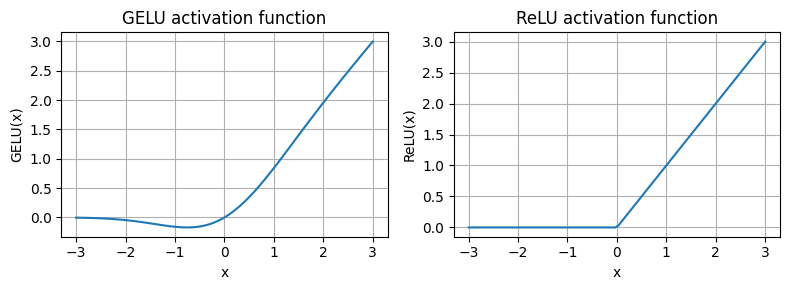

In [47]:
# 导入 matplotlib 绘图库,用于可视化激活函数的形状
import matplotlib.pyplot as plt

# 实例化两个激活函数对象:
# - gelu: 我们自定义的 GELU 激活函数(上面定义的类)
# - relu: PyTorch 内置的 ReLU 激活函数
# 这样可以方便地对比两种激活函数的行为差异
gelu, relu = GELU(), nn.ReLU()

# 生成测试数据:
# torch.linspace(-3, 3, 100) 在 [-3, 3] 区间内均匀生成 100 个点
# 这个范围足够展示激活函数在负值、零点、正值区域的不同表现
x = torch.linspace(-3, 3, 100)

# 将测试数据分别通过两个激活函数,得到输出值:
# - y_gelu: GELU 激活函数的输出,是平滑曲线
# - y_relu: ReLU 激活函数的输出,是分段线性(负值为0,正值保持不变)
y_gelu, y_relu = gelu(x), relu(x)

# 创建一个 8x3 英寸的画布,用于并排显示两个子图
plt.figure(figsize=(8, 3))

# 使用 enumerate 遍历两个激活函数的输出和标签:
# - zip([y_gelu, y_relu], ["GELU", "ReLU"]) 将输出和标签配对
# - enumerate(..., 1) 从 1 开始编号(方便 subplot 索引)
# - i: 子图编号(1 或 2)
# - y: 当前激活函数的输出值
# - label: 当前激活函数的名称("GELU" 或 "ReLU")
for i, (y, label) in enumerate(zip([y_gelu, y_relu], ["GELU", "ReLU"]), 1):
    # 创建 1 行 2 列的子图布局,当前绘制第 i 个子图
    # 1: 总共 1 行
    # 2: 总共 2 列
    # i: 当前子图位置(1=左图, 2=右图)
    plt.subplot(1, 2, i)
    
    # 绘制激活函数曲线:
    # x 轴: 输入值(从 -3 到 3)
    # y 轴: 激活函数的输出值
    plt.plot(x, y)
    
    # 设置子图标题,显示激活函数名称
    plt.title(f"{label} activation function")
    
    # 设置 x 轴标签,表示输入值
    plt.xlabel("x")
    
    # 设置 y 轴标签,表示激活函数的输出值
    # 例如: "GELU(x)" 或 "ReLU(x)"
    plt.ylabel(f"{label}(x)")
    
    # 显示网格线,方便观察函数值的变化趋势
    # 可以清楚看到 ReLU 在 x=0 处的折点,以及 GELU 的平滑过渡
    plt.grid(True)

# 自动调整子图之间的间距,避免标题/标签重叠
plt.tight_layout()

# 显示图形窗口
# 通过对比可以看到:
# - ReLU: 在 x<0 时输出为 0(硬截断),在 x>0 时输出等于输入(斜率为1)
# - GELU: 平滑曲线,在 x<0 时也有非零梯度(除了约 -0.75 处),更适合深度学习
plt.show()

- 正如我们所见，ReLU 是一种分段线性函数：对于正值直接输出输入值；对于负值则输出零。
- GELU 是一种平滑的非线性函数，它近似 ReLU，但在负值时具有非零梯度（除了大约在 -0.75 处）。

- 接下来，我们将实现一个小型神经网络模块 `FeedForward`，该模块将用于 LLM 的 Transformer 块中：

In [48]:
# FeedForward 前馈神经网络模块
# 这是 Transformer 块中的核心组件之一,用于对每个 token 的嵌入向量进行非线性变换
# 典型结构: 线性层 → 激活函数 → 线性层 (也称为 Position-wise Feed-Forward Network)
class FeedForward(nn.Module):
    def __init__(self, cfg):
        """
        初始化前馈网络
        
        参数:
            cfg: 配置字典,包含模型超参数
                 cfg["emb_dim"]: 嵌入维度(例如 GPT-124M 中为 768)
        
        网络结构:
            输入维度 → 4倍扩展维度 → 激活函数 → 压缩回原始维度
            例如: 768 → 3072 → GELU → 768
        """
        super().__init__()
        
        # 使用 nn.Sequential 将多个层按顺序组合成一个模块
        # 前向传播时会自动按顺序执行这些层
        self.layers = nn.Sequential(
            # 第一个线性层: 将嵌入维度扩展到 4 倍
            # 输入: [batch_size, num_tokens, emb_dim]
            # 输出: [batch_size, num_tokens, 4 * emb_dim]
            # 例如: [2, 3, 768] → [2, 3, 3072]
            # 扩展到 4 倍是 Transformer 的标准做法,增加模型的表达能力
            nn.Linear(cfg["emb_dim"], 4 * cfg["emb_dim"]),
            
            # GELU 激活函数: 引入非线性变换
            # 保持形状不变: [batch_size, num_tokens, 4 * emb_dim]
            # GELU 比 ReLU 更平滑,在负值区域也有梯度,有助于训练
            GELU(),
            
            # 第二个线性层: 将维度压缩回原始嵌入维度
            # 输入: [batch_size, num_tokens, 4 * emb_dim]
            # 输出: [batch_size, num_tokens, emb_dim]
            # 例如: [2, 3, 3072] → [2, 3, 768]
            # 这样输出维度与输入维度相同,方便后续的残差连接
            nn.Linear(4 * cfg["emb_dim"], cfg["emb_dim"]),
        )
    
    # 前向传播函数: 定义数据如何流经网络
    # 运行一次 forward 会依次执行: 线性变换 → GELU 激活 → 线性变换
    # 即: 扩展维度 → 非线性激活 → 压缩维度
    def forward(self, x):
        """
        前向传播
        
        参数:
            x: 输入张量,形状为 [batch_size, num_tokens, emb_dim]
               例如: [2, 3, 768] 表示 2 个样本,每个样本 3 个 token,每个 token 768 维
        
        返回:
            输出张量,形状与输入相同 [batch_size, num_tokens, emb_dim]
            例如: [2, 3, 768]
        
        处理流程:
            1. x → Linear(768→3072): 扩展特征维度
            2. → GELU(): 非线性激活
            3. → Linear(3072→768): 压缩回原始维度
        """
        return self.layers(x)

In [49]:
print(GPT_CONFIG_124M["emb_dim"])

768


<img src="../image/09.webp" width="400px">

In [50]:
ffn = FeedForward(GPT_CONFIG_124M)

# input shape: [batch_size, num_token, emb_size]
x = torch.rand(2, 3, 768) 
out = ffn(x)
print(out.shape)

torch.Size([2, 3, 768])


<img src="../image/10.webp" width="400px">

<img src="../image/11.webp" width="400px">

## 4.4 类似于ResNet的shortcut传递

- 接下来，我们来讨论**快捷连接**（shortcut connections）的概念，也称为**跳跃连接**（skip connections）或**残差连接**（residual connections）。
- 残差连接最初是在深度网络中提出的，主要应用于计算机视觉中的残差网络（ResNet），以缓解梯度消失问题。
- 残差连接通过为梯度提供一条更短的替代路径，使其能够更顺畅地通过网络流动。
- 具体实现是将某一层的输出与后续某一层的输出相加，通常会跳过中间的一层或多层。
- 以下是一个小型网络的示例来说明这一概念：

![残差连接示例](../image/12.webp)

- 代码形式长成这样

In [51]:
import torch
import torch.nn as nn

class ExampleDeepNeuralNetwork(nn.Module):
    """
    示例深度神经网络,用于演示残差连接(shortcut/skip/residual connection)的作用
    
    这个网络包含5层线性变换,每层后接GELU激活函数。
    可以选择是否使用残差连接来缓解梯度消失问题。
    """
    def __init__(self, layer_sizes, use_shortcut):
        """
        初始化网络
        
        Args:
            layer_sizes: 列表,定义每层的输入输出维度,长度为6(5层网络需要6个维度值)
                        例如 [3, 3, 3, 3, 3, 1] 表示输入3维,中间层都是3维,输出1维
            use_shortcut: 布尔值,是否使用残差连接
        """
        super().__init__()
        self.use_shortcut = use_shortcut
        
        # 定义多层网络,包含 5 层线性层和激活函数 GELU
        # 每个 nn.Sequential 包含一个线性变换和一个激活函数
        self.layers = nn.ModuleList([
            # 第1层: layer_sizes[0] -> layer_sizes[1]
            nn.Sequential(nn.Linear(layer_sizes[0], layer_sizes[1]), GELU()),
            # 第2层: layer_sizes[1] -> layer_sizes[2]
            nn.Sequential(nn.Linear(layer_sizes[1], layer_sizes[2]), GELU()),
            # 第3层: layer_sizes[2] -> layer_sizes[3]
            nn.Sequential(nn.Linear(layer_sizes[2], layer_sizes[3]), GELU()),
            # 第4层: layer_sizes[3] -> layer_sizes[4]
            nn.Sequential(nn.Linear(layer_sizes[3], layer_sizes[4]), GELU()),
            # 第5层: layer_sizes[4] -> layer_sizes[5]
            nn.Sequential(nn.Linear(layer_sizes[4], layer_sizes[5]), GELU())
        ])
        # 这是一个五层的神经网络块,其中每层包含一个线性变换和一个激活函数 GELU,
        # 类似 ResNet 的结构,支持添加残差连接。

    def forward(self, x):
        """
        前向传播
        
        Args:
            x: 输入张量,形状为 [batch_size, input_dim]
            
        Returns:
            输出张量,形状为 [batch_size, output_dim]
        """
        # 遍历每一层
        for layer in self.layers:
            # 计算当前层的输出
            # layer(x) 会依次执行 Linear 和 GELU
            layer_output = layer(x)
            
            # 检查是否可以应用残差连接
            # 残差连接的条件:
            # 1. use_shortcut 为 True (用户启用了残差连接)
            # 2. x.shape == layer_output.shape (输入输出维度必须相同才能相加)
            if self.use_shortcut and x.shape == layer_output.shape:
                # 残差连接: 将输入 x 与当前层输出相加
                # 这样梯度可以直接通过加法操作流回前面的层,缓解梯度消失
                x = x + layer_output
            else:
                # 不使用残差连接,或者维度不匹配时,直接使用当前层的输出
                x = layer_output
        
        # 返回最终结果(经过所有层处理后的输出)
        return x


def print_gradients(model, x):
    """
    打印模型每层权重的梯度均值,用于观察梯度消失/爆炸现象
    
    Args:
        model: 要分析的神经网络模型
        x: 输入样本
    """
    # 前向传播:计算模型输出
    output = model(x)
    
    # 定义一个简单的目标值(用于计算损失)
    target = torch.tensor([[0.]])
    
    # 计算损失,使用均方误差损失函数 (MSE Loss)
    # MSE = mean((output - target)^2)
    loss = nn.MSELoss()
    loss = loss(output, target)
    
    # 反向传播,计算所有参数的梯度
    # 这会填充每个参数的 .grad 属性
    loss.backward()

    # 遍历模型的所有参数,打印权重参数的梯度均值
    for name, param in model.named_parameters():
        # 只关注权重参数(weight),不关注偏置(bias)
        if 'weight' in name:
            # 计算梯度的绝对值的平均值
            # 如果这个值很小(接近0),说明该层存在梯度消失问题
            # 如果这个值很大,说明该层可能存在梯度爆炸问题
            print(f"{name} has gradient mean of {param.grad.abs().mean().item()}")

- 在没有残差链接的时候,梯度是这样的

In [52]:
# 定义一个深层神经网络的结构
# layer_sizes 列表定义了每一层的神经元数量:
# - 输入层: 3个神经元
# - 4个隐藏层: 每层3个神经元
# - 输出层: 1个神经元
# 总共5层(不包括输入层),这是一个相对较深的网络,容易出现梯度消失问题
layer_sizes = [3, 3, 3, 3, 3, 1]  

# 创建一个样本输入张量
# shape: [1, 3] 表示 batch_size=1, 输入特征维度=3
# 值 [1., 0., -1.] 是一个简单的测试输入,包含正数、零和负数
sample_input = torch.tensor([[1., 0., -1.]])

# 设置随机种子,确保实验的可重复性
# 这样每次运行代码时,网络的初始权重都是相同的
torch.manual_seed(123)

# 创建一个 **不使用残差连接** 的深层神经网络
# use_shortcut=False 表示禁用残差连接(shortcut connections)
# 这个模型将展示传统深层网络的梯度消失问题
model_without_shortcut = ExampleDeepNeuralNetwork(
    layer_sizes, use_shortcut=False
)

# 打印每一层权重的梯度均值
# 目的: 观察在没有残差连接的情况下,梯度如何在反向传播过程中逐层衰减
# 预期结果: 越靠近输入层(layer.0),梯度越小,说明存在梯度消失现象
# 这会导致前面的层难以学习,训练效果差
print_gradients(model_without_shortcut, sample_input)

layers.0.0.weight has gradient mean of 0.00020173587836325169
layers.1.0.weight has gradient mean of 0.0001201116101583466
layers.2.0.weight has gradient mean of 0.0007152041071094573
layers.3.0.weight has gradient mean of 0.0013988735154271126
layers.4.0.weight has gradient mean of 0.005049645435065031


- **有** 残差的链接,梯度是这样的

In [53]:
torch.manual_seed(123)
model_with_shortcut = ExampleDeepNeuralNetwork(
    layer_sizes, use_shortcut=True
)
print_gradients(model_with_shortcut, sample_input)
#引入了残差链接,发现梯度消失的缺点明显改善了

layers.0.0.weight has gradient mean of 0.22169791162014008
layers.1.0.weight has gradient mean of 0.20694106817245483
layers.2.0.weight has gradient mean of 0.32896995544433594
layers.3.0.weight has gradient mean of 0.2665732204914093
layers.4.0.weight has gradient mean of 1.3258540630340576


- 正如我们从上述输出中看到的，残差连接有效地防止了梯度在早期层（靠近 `layer.0`）中消失。
- 接下来，在实现 Transformer 块时，我们将使用这一残差连接的概念。

## 4.5 在 Transformer 块中连接attention层与线性层

- 在本节中，我们将把前面介绍的概念整合成一个所谓的 Transformer 块。
- Transformer 块将上一章中的因果多头注意力模块与线性层以及我们之前实现的前馈神经网络相结合。
- 此外，Transformer 块还包含 Dropout 和残差连接的机制。

In [54]:
from previous_chapters import MultiHeadAttention


class TransformerBlock(nn.Module):
    """
    Transformer 块 - GPT 架构的核心组件
    
    这个模块实现了标准的 Transformer 块结构,包含:
    1. 多头自注意力机制 (Multi-Head Self-Attention)
    2. 前馈神经网络 (Feed-Forward Network)
    3. 层归一化 (Layer Normalization)
    4. 残差连接 (Residual Connections)
    5. Dropout 正则化
    
    结构流程:
        输入 -> LayerNorm -> MultiHeadAttention -> Dropout -> 残差连接
             -> LayerNorm -> FeedForward -> Dropout -> 残差连接 -> 输出
    """
    def __init__(self, cfg):
        """
        初始化 Transformer 块
        
        参数:
            cfg: 配置字典,包含以下关键参数:
                - emb_dim: 嵌入维度 (例如 768)
                - context_length: 上下文长度 (例如 1024)
                - n_heads: 注意力头数量 (例如 12)
                - drop_rate: Dropout 比例 (例如 0.1)
                - qkv_bias: 是否在 Q/K/V 投影中使用偏置
        """
        super().__init__()
        
        # 多头注意力模块 - 让模型能够关注输入序列中不同位置的信息
        self.att = MultiHeadAttention(
            d_in=cfg["emb_dim"],               # 输入特征维度 (例如 768)
            d_out=cfg["emb_dim"],              # 输出特征维度 (保持与输入相同)
            context_length=cfg["context_length"],  # 上下文长度 (最大序列长度)
            num_heads=cfg["n_heads"],          # 注意力头的数量 (例如 12 个头)
            dropout=cfg["drop_rate"],          # 注意力权重的 Dropout 比例
            qkv_bias=cfg["qkv_bias"]           # 查询、键和值投影矩阵是否使用偏置
        )
        
        # 前馈神经网络模块 - 对每个位置独立应用的两层全连接网络
        # 通常会先扩展维度(例如 768 -> 3072),再压缩回原维度(3072 -> 768)
        self.ff = FeedForward(cfg)
        
        # 第一个层归一化 - 在注意力层之前应用
        # 作用: 稳定训练,加速收敛,缓解梯度消失/爆炸问题
        self.norm1 = LayerNorm(cfg["emb_dim"])
        
        # 第二个层归一化 - 在前馈网络之前应用
        self.norm2 = LayerNorm(cfg["emb_dim"])
        
        # 残差连接的 Dropout - 用于正则化,防止过拟合
        # 注意: 这个 Dropout 会应用在残差连接的路径上
        self.drop_shortcut = nn.Dropout(cfg["drop_rate"])

    def forward(self, x):
        """
        前向传播
        
        参数:
            x: 输入张量,形状为 [batch_size, num_tokens, emb_dim]
               例如 [2, 4, 768] 表示 2 个样本,每个样本 4 个 token,每个 token 768 维
        
        返回:
            输出张量,形状与输入相同 [batch_size, num_tokens, emb_dim]
        
        实现细节:
            采用 Pre-LN (Pre-Layer Normalization) 结构:
            - 先归一化,再应用子层 (注意力或前馈网络)
            - 这种结构比 Post-LN 更稳定,训练更容易
        """
        # ========== 第一个子层: 多头自注意力 + 残差连接 ==========
        
        # 保存输入作为残差连接的快捷路径
        # 这样可以让梯度直接流向前面的层,缓解梯度消失问题
        shortcut = x
        
        # 步骤 1: 层归一化 - 标准化特征分布
        # 对最后一个维度 (emb_dim) 进行归一化,使均值为 0,方差为 1
        x = self.norm1(x)
        
        # 步骤 2: 多头自注意力 - 让每个 token 关注序列中的其他 token
        # 输入形状: [batch_size, num_tokens, emb_dim]
        # 输出形状: [batch_size, num_tokens, emb_dim] (形状保持不变)
        x = self.att(x)
        
        # 步骤 3: Dropout - 随机丢弃一些神经元,防止过拟合
        x = self.drop_shortcut(x)
        
        # 步骤 4: 残差连接 - 将原始输入加回来
        # 这是关键操作: x_out = x_processed + x_original
        # 好处: 1) 梯度可以直接流向前面的层  2) 保留原始信息
        x = x + shortcut
        
        # ========== 第二个子层: 前馈神经网络 + 残差连接 ==========
        
        # 再次保存当前状态作为残差连接的快捷路径
        shortcut = x
        
        # 步骤 5: 层归一化 - 再次标准化特征分布
        x = self.norm2(x)
        
        # 步骤 6: 前馈神经网络 - 对每个位置独立应用非线性变换
        # 通常结构: Linear(768->3072) -> GELU -> Linear(3072->768)
        # 作用: 增加模型的表达能力,引入非线性
        x = self.ff(x)
        
        # 步骤 7: Dropout - 再次应用 Dropout 正则化
        x = self.drop_shortcut(x)
        
        # 步骤 8: 残差连接 - 再次将输入加回来
        x = x + shortcut
        
        # 返回最终输出,形状与输入完全相同
        # 这个输出可以看作是"增强版"的上下文向量
        # 它融合了自注意力机制捕获的全局信息和前馈网络提取的局部特征
        return x

<img src="../image/13.webp" width="400px">

- 假设我们有 2 个输入样本，每个样本包含 6 个标记，每个标记是一个 768 维的嵌入向量；然后，这个 Transformer 块会先应用自注意力机制，再通过线性层处理，生成一个相同尺寸的输出。
- 你可以将输出视为我们在上一章讨论的上下文向量的增强版本。

In [55]:
# ========== 测试 TransformerBlock 的输入输出形状 ==========

# 设置随机种子,确保结果可复现
torch.manual_seed(123)

# 创建一个模拟的输入张量
# 形状解释:
#   - 2: batch_size,表示批次中有 2 个样本
#   - 4: num_tokens,表示每个样本有 4 个标记(token)
#   - 768: emb_dim,表示每个标记的嵌入维度是 768
# 这个张量模拟了经过 token embedding 和 position embedding 后的输入
x = torch.rand(2, 4, 768)  # Shape: [batch_size, num_tokens, emb_dim]

# 实例化一个 TransformerBlock
# 使用 GPT_CONFIG_124M 配置(124M 参数的 GPT-2 模型配置)
# 这个 block 包含:
#   1. 多头自注意力层(MultiHeadAttention)
#   2. 前馈神经网络(FeedForward)
#   3. 两个层归一化(LayerNorm)
#   4. 两个残差连接
block = TransformerBlock(GPT_CONFIG_124M)

# 将输入传递给 TransformerBlock,得到输出
# 内部流程:
#   x -> LayerNorm -> MultiHeadAttention -> Dropout -> 残差连接
#   -> LayerNorm -> FeedForward -> Dropout -> 残差连接 -> output
output = block(x)

# 打印输入和输出的形状
# 关键观察: 输入和输出的形状完全相同!
# 这是 Transformer 架构的重要特性 - 形状保持不变
print("Input shape:", x.shape)      # 预期输出: torch.Size([2, 4, 768])
print("Output shape:", output.shape) # 预期输出: torch.Size([2, 4, 768])

# 这个测试验证了:
# 1. TransformerBlock 可以正确处理批量输入
# 2. 输出形状与输入形状一致,可以堆叠多个 block
# 3. 每个 token 的表示从 768 维输入变成 768 维输出(维度不变,但内容已被增强)

Input shape: torch.Size([2, 4, 768])
Output shape: torch.Size([2, 4, 768])


<img src="../image/14.webp" width="400px">

## 4.6 编码GPT

- 终于要结束了：现在让我们将 Transformer 块插入到本章开头编写的架构中，这样就可以得到一个可用的 GPT 架构。
- 请注意，Transformer 块会重复多次；对于最小的 124M GPT-2 模型来说，我们会重复 12 次。

<img src="../image/15.webp" width="400px">

- 对应的代码实现，其中 `cfg["n_layers"] = 12`：

- (译者)一点语法小知识
在 Python 中，* 是 解包操作符，用于将一个可迭代对象（如列表、元组）中的元素逐一解包成单独的参数。
在 PyTorch 中，nn.Sequential 接受一组模块作为输入，而不是一个列表或其他容器。
这里使用 * 将生成的 TransformerBlock 列表解包为独立的参数传递给 nn.Sequential。

In [56]:
class GPTModel(nn.Module):  # GPT 模型的完整实现
    """
    GPT (Generative Pre-trained Transformer) 模型
    
    这是一个完整的 GPT 架构实现,包含:
    1. Token 嵌入层 (tok_emb): 将词汇表中的 token ID 转换为向量表示
    2. 位置嵌入层 (pos_emb): 为每个 token 添加位置信息
    3. Dropout 层 (drop_emb): 防止过拟合
    4. Transformer 块堆叠 (trf_blocks): 核心的自注意力和前馈网络层
    5. 最终归一化层 (final_norm): 稳定输出
    6. 输出投影层 (out_head): 将嵌入向量映射回词汇表大小
    """
    def __init__(self, cfg):
        """
        初始化 GPT 模型
        
        参数:
            cfg: 配置字典,包含以下关键参数:
                - vocab_size: 词汇表大小 (例如 50257)
                - emb_dim: 嵌入维度 (例如 768)
                - context_length: 最大序列长度 (例如 1024)
                - drop_rate: Dropout 比率 (例如 0.1)
                - n_layers: Transformer 块的数量 (例如 12)
        """
        super().__init__()
        
        # 1. Token 嵌入层: 将 token ID (整数) 映射为 emb_dim 维的向量
        # 例如: vocab_size=50257, emb_dim=768
        # 输入形状: [batch_size, seq_len] (整数索引)
        # 输出形状: [batch_size, seq_len, emb_dim]
        self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"])
        
        # 2. 位置嵌入层: 为序列中的每个位置学习一个固定的向量表示
        # context_length 是模型能处理的最大序列长度
        # 位置 0, 1, 2, ... 各有一个可学习的 emb_dim 维向量
        # 输入: 位置索引 [0, 1, 2, ..., seq_len-1]
        # 输出形状: [seq_len, emb_dim]
        self.pos_emb = nn.Embedding(cfg["context_length"], cfg["emb_dim"])
        
        # 3. Dropout 层: 在训练时随机将一部分神经元输出置零,防止过拟合
        # drop_rate 控制丢弃的比例 (例如 0.1 表示丢弃 10%)
        self.drop_emb = nn.Dropout(cfg["drop_rate"])
        
        # 4. Transformer 块堆叠: 这是 GPT 的核心部分
        # 使用列表推导式创建 n_layers 个 TransformerBlock
        # * 操作符将列表解包为独立参数传递给 nn.Sequential
        # 例如: n_layers=12 时,会创建 12 个 TransformerBlock 依次执行
        # 每个 block 包含: 多头注意力 + 前馈网络 + 残差连接 + LayerNorm
        self.trf_blocks = nn.Sequential(
            *[TransformerBlock(cfg) for _ in range(cfg["n_layers"])])
        
        # 注意: 下面这段重复定义的代码会覆盖上面的 self.trf_blocks
        # 这里只创建了 3 个 TransformerBlock,可能是用于调试或演示
        # 在实际使用中应该删除这段代码,使用上面的动态创建版本
        self.trf_blocks = nn.Sequential(
            TransformerBlock(cfg),  # 第 1 个 Transformer 块
            TransformerBlock(cfg),  # 第 2 个 Transformer 块
            TransformerBlock(cfg)   # 第 3 个 Transformer 块
        )
        
        # 5. 最终的 Layer Normalization: 在输出前对特征进行归一化
        # 作用: 稳定训练,加速收敛,减少梯度消失/爆炸问题
        # 对最后一个维度 (emb_dim) 进行归一化
        self.final_norm = LayerNorm(cfg["emb_dim"])
        
        # 6. 输出投影层: 将 emb_dim 维的向量映射回 vocab_size 维
        # 这样可以为词汇表中的每个 token 计算一个分数 (logit)
        # bias=False: 不使用偏置项 (GPT-2 的标准做法)
        # 输入形状: [batch_size, seq_len, emb_dim]
        # 输出形状: [batch_size, seq_len, vocab_size]
        self.out_head = nn.Linear(
            cfg["emb_dim"], cfg["vocab_size"], bias=False
        )
    
    def forward(self, in_idx):
        """
        前向传播函数: 将输入的 token 索引转换为输出 logits
        
        参数:
            in_idx: 输入的 token 索引张量
                   形状: [batch_size, seq_len]
                   例如: [[15496, 11, 314, 1101], [262, 1218, 286, 257]]
        
        返回:
            logits: 每个位置对词汇表中每个 token 的未归一化分数
                   形状: [batch_size, seq_len, vocab_size]
                   可以通过 softmax 转换为概率分布
        
        处理流程:
            输入 token IDs → Token 嵌入 → 加上位置嵌入 → Dropout 
            → Transformer 块堆叠 → LayerNorm → 输出投影 → Logits
        """
        # 获取批次大小和序列长度
        # 例如: in_idx.shape = [2, 4] 表示 2 个样本,每个样本 4 个 token
        batch_size, seq_len = in_idx.shape
        
        # 步骤 1: 将 token ID 转换为嵌入向量
        # 输入: [batch_size, seq_len] 的整数索引
        # 输出: [batch_size, seq_len, emb_dim] 的浮点数向量
        tok_embeds = self.tok_emb(in_idx)
        
        # 步骤 2: 生成位置嵌入
        # torch.arange(seq_len) 创建 [0, 1, 2, ..., seq_len-1]
        # device=in_idx.device 确保位置索引与输入在同一设备 (CPU/GPU)
        # 输出: [seq_len, emb_dim] 的位置向量
        pos_embeds = self.pos_emb(torch.arange(seq_len, device=in_idx.device))
        
        # 步骤 3: 将 token 嵌入和位置嵌入相加
        # pos_embeds 会自动广播到 [batch_size, seq_len, emb_dim]
        # 这样每个 token 的表示就同时包含了"内容信息"和"位置信息"
        # 形状: [batch_size, seq_len, emb_dim]
        x = tok_embeds + pos_embeds
        
        # 步骤 4: 应用 Dropout 正则化
        # 在训练时随机丢弃一些神经元,防止过拟合
        # 在推理时不起作用 (model.eval() 模式下)
        x = self.drop_emb(x)
        
        # 步骤 5: 通过所有 Transformer 块进行处理
        # 每个块都会应用自注意力机制和前馈网络
        # 输入和输出形状保持不变: [batch_size, seq_len, emb_dim]
        x = self.trf_blocks(x)
        
        # 步骤 6: 最终的 Layer Normalization
        # 对输出进行归一化,稳定数值范围
        x = self.final_norm(x)
        
        # 步骤 7: 通过输出层投影到词汇表空间
        # 将 emb_dim 维的向量映射为 vocab_size 维的 logits
        # logits[i, j, k] 表示第 i 个样本的第 j 个位置预测第 k 个 token 的分数
        # 形状: [batch_size, seq_len, vocab_size]
        logits = self.out_head(x)
        
        return logits

- 用了124M模型的原始参数,我们接下啦要初始化模型参数

In [57]:
torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)

out = model(batch)
print("Input batch:\n", batch)
print("\nOutput shape:", out.shape)
print(out)
#经典操作

Input batch:
 tensor([[6109, 3626, 6100,  345],
        [6109, 1110, 6622,  257]])

Output shape: torch.Size([2, 4, 50257])
tensor([[[ 0.1288, -0.0010, -0.8699,  ..., -0.0127, -0.3599,  0.0275],
         [ 0.5068, -0.2318,  0.2832,  ..., -0.5274,  0.0906, -0.7593],
         [ 1.0905, -0.6728, -0.8097,  ...,  0.7395,  0.4309, -0.2174],
         [-0.9789, -0.2985,  0.1336,  ..., -0.4023,  0.0093,  0.1462]],

        [[-0.1734, -0.3146, -0.5338,  ..., -0.0521, -0.0971,  0.1293],
         [ 0.8129,  0.1875, -0.1978,  ...,  0.8638,  0.0565, -0.9834],
         [ 0.7845, -0.3407,  0.1625,  ..., -0.2429,  0.1776, -0.4528],
         [ 0.0278,  0.4425, -0.2536,  ...,  0.5252,  0.4567,  0.2523]]],
       grad_fn=<UnsafeViewBackward0>)


- 我们将在下一章训练这个模型。
- 但关于其规模需要补充一点：我们之前提到它是一个拥有 1.24 亿参数的模型；我们可以通过以下方式再次确认这个数字：

In [58]:
# 计算模型的总参数数量
# model.parameters() 返回模型中所有可训练参数的迭代器
# p.numel() 返回每个参数张量中元素的总数（number of elements）
# 例如：一个形状为 [768, 50257] 的权重矩阵有 768 * 50257 = 38,597,376 个参数
# sum() 将所有层的参数数量累加起来，得到模型的总参数量
total_params = sum(p.numel() for p in model.parameters())

# 打印总参数数量
# :, 格式化符号会在数字中添加千位分隔符，使大数字更易读
# 例如：163009536 会显示为 163,009,536
print(f"Total number of parameters: {total_params:,}")

Total number of parameters: 99,239,424


- 正如我们上面看到的，这个模型实际上有 1.63 亿参数，而不是 1.24 亿；这是为什么呢？
- 在原始 GPT-2 论文中，研究人员采用了**权重共享**（weight tying）技术，即将标记嵌入层（`tok_emb`）作为输出层复用，具体表现为设置 `self.out_head.weight = self.tok_emb.weight`。
- 标记嵌入层将 50,257 维的独热编码输入标记映射到 768 维的嵌入表示。
- 输出层则将 768 维的嵌入表示映射回 50,257 维的表示，从而可以将其还原为单词（关于这一点，我们将在下一节详细讨论）。
- 因此，嵌入层和输出层的权重参数数量相同，从它们权重矩阵的形状可以看出这一点。

In [59]:
print("Token embedding layer shape:", model.tok_emb.weight.shape)
print("Output layer shape:", model.out_head.weight.shape)
#输出格式让我们更好地理解

Token embedding layer shape: torch.Size([50257, 768])
Output layer shape: torch.Size([50257, 768])


- 在原始 GPT-2 论文中，研究人员将标记嵌入矩阵复用为输出矩阵。
- 相应地，如果我们减去输出层的参数数量，就会得到一个拥有 1.24 亿参数的模型：

In [60]:
total_params_gpt2 =  total_params - sum(p.numel() for p in model.out_head.parameters())
print(f"Number of trainable parameters considering weight tying: {total_params_gpt2:,}")
#Parameter- sharing

Number of trainable parameters considering weight tying: 60,642,048


- 在实际应用中，因为不使用权重共享更容易训练模型，所以这里没有进行权重共享。
- 不过，在第 5 章加载预训练权重时，我们将重新讨论并应用权重共享的概念。
- 最后，我们可以通过以下方式计算模型的内存需求，这可能是一个有用的参考点：

In [61]:
# 计算模型的总内存占用（以字节为单位）
# 假设模型使用 float32 数据类型存储参数，每个参数占用 4 字节
# float32 是深度学习中最常用的数据类型：
#   - float16（半精度）：2 字节/参数
#   - float32（单精度）：4 字节/参数
#   - float64（双精度）：8 字节/参数
# 因此，总字节数 = 参数总数 × 每个参数的字节数
total_size_bytes = total_params * 4

# 将字节转换为兆字节（MB），便于理解模型大小
# 转换公式：1 MB = 1024 KB = 1024 × 1024 字节 = 1,048,576 字节
# 例如：如果 total_params = 163,009,536，则：
#   total_size_bytes = 163,009,536 × 4 = 652,038,144 字节
#   total_size_mb = 652,038,144 / 1,048,576 ≈ 621.83 MB
total_size_mb = total_size_bytes / (1024 * 1024)

# 打印模型的总大小（以 MB 为单位）
# :.2f 格式化符号表示保留两位小数
# 这个大小仅包含模型参数本身，不包括：
#   - 训练时的梯度（需要额外相同大小的内存）
#   - 优化器状态（如 Adam 需要额外 2 倍参数大小的内存）
#   - 激活值（前向传播时的中间结果）
print(f"Total size of the model: {total_size_mb:.2f} MB")

Total size of the model: 378.57 MB


- **练习**：你可以尝试以下其他配置，这些配置参考自 [GPT-2 论文](https://scholar.google.com/citations?view_op=view_citation&hl=en&user=dOad5HoAAAAJ&citation_for_view=dOad5HoAAAAJ:YsMSGLbcyi4C)。

    - **GPT2-small**（我们已经实现的 124M 配置）：
        - `"emb_dim" = 768`
        - `"n_layers" = 12`
        - `"n_heads" = 12`

    - **GPT2-medium**：
        - `"emb_dim" = 1024`
        - `"n_layers" = 24`
        - `"n_heads" = 16`

    - **GPT2-large**：
        - `"emb_dim" = 1280`
        - `"n_layers" = 36`
        - `"n_heads" = 20`

    - **GPT2-XL**：
        - `"emb_dim" = 1600`
        - `"n_layers" = 48`
        - `"n_heads" = 25`

## 4.7 文本生成

- GPT架构的LLM一次只能生成一个单词

<img src="../image/16.webp" width="400px">

- 以下的 `generate_text_simple` 函数实现了贪心解码（greedy decoding），这是一种简单且快速的文本生成方法。
- 在贪心解码中，模型在每一步选择具有最高概率的词（或标记）作为下一个输出（由于最高的 logit 值对应最高的概率，实际上我们不需要显式地计算 softmax 函数）。
- 在下一章，我们将实现一个更为复杂的 `generate_text` 函数。
- 下图展示了给定输入上下文时，GPT 模型是如何生成下一个词标记的。

<img src="../image/17.webp" width="600px">

In [62]:
def generate_text_simple(model, idx, max_new_tokens, context_size):
    # 预测单词的模块
    # idx 是当前上下文中的（batch, n_tokens）索引数组
    for _ in range(max_new_tokens):
        # 每次生成一个单词后，重新将其加入序列中
        # 如果当前上下文长度超过模型支持的最大上下文长度，则截取
        # 例如，如果LLM只支持5个token，而上下文长度为10
        # 那么只使用最后5个token作为上下文
        idx_cond = idx[:, -context_size:]
        # 如果idx的长度超过模型支持的上下文长度size，只保留最后size个token
        # 避免溢出
        # 获取预测结果
        with torch.no_grad():  # 在推理阶段，不需要计算梯度，因为没有反向传播
            # 这样可以减少存储开销
            logits = model(idx_cond)
            # 模型输出结果
        # 只关注最后一个时间步的输出
        # (batch, n_tokens, vocab_size) 变为 (batch, vocab_size)
        logits = logits[:, -1, :]
        # 关注最后一个时间步
        # 使用softmax函数计算概率
        probas = torch.softmax(logits, dim=-1)  # (batch, vocab_size)
        # 归一化
        # 获取具有最高概率值的词汇索引
        idx_next = torch.argmax(probas, dim=-1, keepdim=True)  # (batch, 1)
        # 获取概率最高的词汇索引
        # 将采样的索引添加到序列中
        idx = torch.cat((idx, idx_next), dim=1)  # (batch, n_tokens+1)

    return idx

- 上面的 `generate_text_simple` 实现了一个迭代过程，其中它一次生成一个token。

<img src="../image/18.webp" width="600px">

- 举个例子

In [63]:
# 定义起始上下文文本（模型生成的起点）
start_context = "Hello, I am"

# 步骤1: 将文本编码为token ID序列
# tokenizer.encode() 会将输入字符串转换为整数列表
# 例如: "Hello, I am" -> [15496, 11, 314, 716]
# 每个整数对应词汇表中的一个token
encoded = tokenizer.encode(start_context)
print("encoded:", encoded)
# 输出示例: encoded: [15496, 11, 314, 716]

# 步骤2: 将Python列表转换为PyTorch张量，并添加批次维度
# torch.tensor(encoded) 将列表转为1维张量，形状为 (n_tokens,)
# unsqueeze(0) 在第0维添加批次维度，形状变为 (1, n_tokens)
# 这是因为模型期望输入格式为 (batch_size, sequence_length)
# 即使只处理一个样本，也需要批次维度
encoded_tensor = torch.tensor(encoded).unsqueeze(0)
print("encoded_tensor.shape:", encoded_tensor.shape)
# 输出示例: encoded_tensor.shape: torch.Size([1, 4])
# 表示批次大小为1，序列长度为4个token

encoded: [15496, 11, 314, 716]
encoded_tensor.shape: torch.Size([1, 4])


In [64]:
# 步骤3: 将模型设置为评估模式
# model.eval() 会禁用 dropout 和 batch normalization 的训练行为
# 在推理/生成阶段,我们不需要随机丢弃神经元(dropout),需要模型的确定性输出
# 这确保每次运行生成的结果是一致的(给定相同的输入和模型参数)
model.eval()

# 步骤4: 调用文本生成函数
# 使用我们之前定义的 generate_text_simple 函数来生成新的token
out = generate_text_simple(
    model=model,
    # 参数说明: model 是我们要使用的 GPT 模型实例
    # 左边是函数定义中的参数名,右边是我们传入的实际对象
    
    idx=encoded_tensor,
    # idx 是输入的上下文token序列,形状为 (1, 4)
    # 这是模型生成的起点,模型会基于这个上下文继续生成
    
    max_new_tokens=6,
    # 指定要生成的新token数量
    # 模型会迭代6次,每次生成1个token
    # 最终输出长度 = 初始上下文长度(4) + 新生成的token数(6) = 10
    
    context_size=GPT_CONFIG_124M["context_length"]
    # 指定模型的上下文窗口大小(本例中为256)
    # 这是模型在生成每个新token时能"看到"的最大历史token数
    # 如果生成的序列超过这个长度,只会使用最近的 context_length 个token
)

# 步骤5: 打印生成结果
print("Output:", out)
# 输出完整的token ID张量,形状为 (1, 10)
# 包含原始的4个输入token + 新生成的6个token

print("Output length:", len(out[0]))
# 打印第一个(也是唯一一个)批次样本的序列长度
# out[0] 移除批次维度后得到形状为 (10,) 的张量
# len() 返回序列中token的总数,应该是 10
# 注意: 这里的长度是token ID的数量,不是字符或单词的数量

Output: tensor([[15496,    11,   314,   716, 37418,  5604, 14311,  6900, 24252,  7098]])
Output length: 10


- 去除批次维度并将其转换回文本

In [65]:
decoded_text = tokenizer.decode(out.squeeze(0).tolist())
print(decoded_text)

Hello, I amrievingourneyAmongersioninasrazil


- 请注意，目前模型尚未经过训练，因此上述输出文本是随机的。
- 我们将在下一章中训练模型。

## 总结与收获

- 请查看 [./gpt.py](./gpt.py) 脚本，这是一个独立的脚本，包含了我们在此 Jupyter Notebook 中实现的 GPT 模型。
- 练习题的解答可以在 [./exercise-solutions.ipynb](./exercise-solutions.ipynb) 中找到。